In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, 
    roc_auc_score, roc_curve, precision_recall_curve, 
    confusion_matrix, classification_report
)
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [2]:
# Define the Dataset class for Keras
class FundusDataset:
    def __init__(self, csv_file, img_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data_frame.iloc[idx, 0] + ".png")
        try:
            image = Image.open(img_name).convert('RGB')
            image = image.resize((224, 224))  # Resize to match model input size
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
            return None, None

        if self.transform:
            image = self.transform(image)

        image = img_to_array(image)  # Convert PIL image to Numpy array
        image = preprocess_input(image)  # Normalize the image if needed

        label = self.data_frame.iloc[idx, 1]
        return image, label


In [3]:
# Load the test dataset
test_images_directory = os.path.join('..', '..', 'Data', 'APTOS-2019 Dataset', 'test_images')
test_csv_file = os.path.join('..', '..', 'Data', 'APTOS-2019 Dataset', 'binary_test.csv')

# Prepare the test dataset
test_dataset = FundusDataset(csv_file=test_csv_file, img_dir=test_images_directory)
test_images = []
test_labels = []

for i in range(len(test_dataset)):
    image, label = test_dataset[i]
    if image is not None:
        test_images.append(image)
        test_labels.append(label)

# Convert to Numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Load the trained Keras model
model_path = os.path.join('..', '..', 'CNN_model_fold_2.keras')
model = load_model(model_path)

# Set the model to evaluation mode
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,507,269 (127.82 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,338,180 (85.21 MB)

In [4]:
# Predict on the test data
predictions = model.predict(test_images)
probs = predictions.ravel()  # Flatten the output probabilities
preds = (probs > 0.5).astype(int)  # Threshold to convert probabilities to binary predictions

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 375ms/step


In [5]:
# Evaluate the model
accuracy = accuracy_score(test_labels, preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 75.96%


In [6]:
f1 = f1_score(test_labels, preds)
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.70


In [7]:
precision = precision_score(test_labels, preds)
recall = recall_score(test_labels, preds)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Precision: 0.81
Recall: 0.62


In [8]:
roc_auc = roc_auc_score(test_labels, probs)
print(f"ROC AUC Score: {roc_auc:.2f}")

ROC AUC Score: 0.76


In [9]:
# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.87      0.80       199
           1       0.81      0.62      0.70       167

    accuracy                           0.76       366
   macro avg       0.77      0.75      0.75       366
weighted avg       0.77      0.76      0.75       366



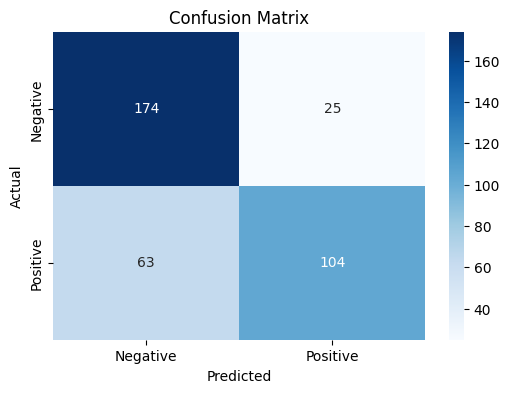

In [10]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels, preds)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

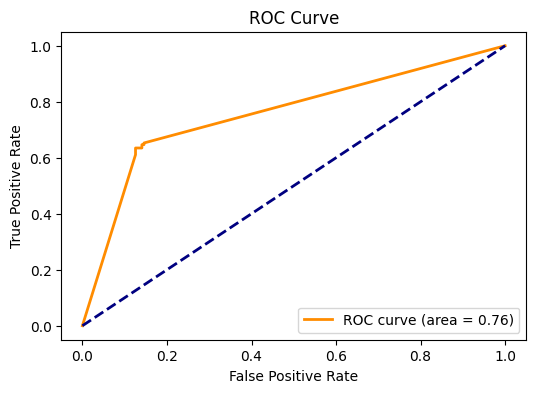

In [11]:
# ROC Curve
fpr, tpr, _ = roc_curve(test_labels, probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

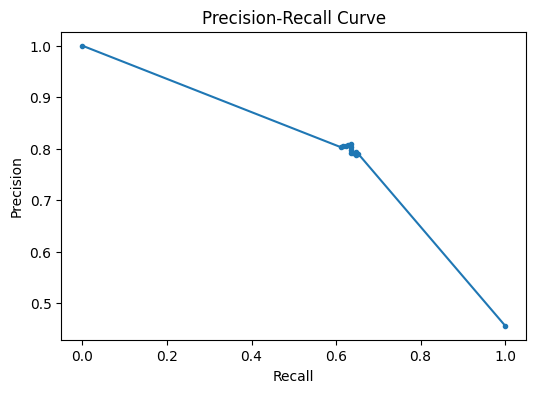

In [12]:
# Precision-Recall curve
precision_vals, recall_vals, thresholds = precision_recall_curve(test_labels, probs)
plt.figure(figsize=(6, 4))
plt.plot(recall_vals, precision_vals, marker='.')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()